Hello @everyone, This is the last necessary task for this project I know it worked out pretty slow, but still all the best for your intern season(Y21's), as well as acads.\
This is a good read on sentiment analysis.https://www.kaggle.com/code/emirkocak/in-depth-series-sentiment-analysis-w-transformers/notebookAssignment this time is for the sentiment analysis of a financial loan i.e. is giving a loan feasible or not in a particular scenario. \
Do apply 2-3 model's like Naive-bayes etc. and compare the result obtained using the ROC-AUC score stc. The dataset can be found below this message. \
I want you guys to give some extra efforts IF you can to try and deploy the model and create an endpoint to use. It's not necessary but can be an interesting task. (edited)


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data_1.csv to data_1.csv


### Imports

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import seaborn as sns
import re
import string
from collections import Counter, defaultdict

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords_nltk = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Helper Functions

In [ ]:
import re
from typing import Union, List

class CleanText():
    """ clearing text except digits () . , word character """

    def __init__(self, clean_pattern = r"[^A-ZĞÜŞİÖÇIa-zğüı'şöç0-9.\"',()]"):
        self.clean_pattern =clean_pattern

    def __call__(self, text: Union[str, list]) -> List[List[str]]:

        if isinstance(text, str):
            docs = [[text]]

        if isinstance(text, list):
            docs = text

        text = [[re.sub(self.clean_pattern, " ", sent) for sent in sents] for sents in docs]

        return text

def remove_emoji(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def tokenize(text):
    """ basic tokenize method with word character, non word character and digits """
    text = re.sub(r" +", " ", str(text))
    text = re.split(r"(\d+|[a-zA-ZğüşıöçĞÜŞİÖÇ]+|\W)", text)
    text = list(filter(lambda x: x != '' and x != ' ', text))
    sent_tokenized = ' '.join(text)
    return sent_tokenized

regex = re.compile('[%s]' % re.escape(string.punctuation))

def remove_punct(text):
    text = regex.sub(" ", text)
    return text

clean = CleanText()

In [ ]:
# label encode
def label_encode(x):
    if x == 1 or x == 2:
        return 0
    if x == 3:
        return 1
    if x == 5 or x == 4:
        return 2

 # label to name
def label2name(x):
    if x == 0:
        return "Negative"
    if x == 1:
        return "Neutral"
    if x == 2:
        return "Positive"

### Read Data

In [ ]:
df = pd.read_csv("data_1.csv")

In [ ]:
# show column names
print("df.columns: ", df.columns)

df.columns:  Index(['Sentence', 'Sentiment'], dtype='object')


In [ ]:
# head of df
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [ ]:
df["Sentiment"].value_counts()

neutral     2916
positive    1706
negative     776
Name: Sentiment, dtype: int64

In [ ]:
def name2label(x):
    if(x=="negative"):
        return 0
    if(x=="neutral"):
        return 1
    if(x=="positive"):
        return 2
df["label"] = df["Sentiment"].apply(lambda x : name2label(x))

In [ ]:
df["Sentence"] = df["Sentence"].apply(lambda x: remove_punct(clean(remove_emoji(x).lower())[0][0]))

In [ ]:
df.head()

,Sentence,Sentiment,label
0,the geosolutions technology will leverage bene...,positive,2
1,esi on lows down 1 50 to 2 50 bk a real po...,negative,0
2,for the last quarter of 2010 componenta s n...,positive,2
3,according to the finnish russian chamber of co...,neutral,1
4,the swedish buyout firm has sold its remaining...,neutral,1


## Visualizations

### Word Cloud
Word clouds generators work by breaking the text down into component words and counting how frequently they appear in the body of text. We can quickly obtain preliminary information about the data. We can understand what a dataset we don't know is talking about.

In [ ]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=40,
        scale=1,
        random_state=1
).generate(" ".join(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

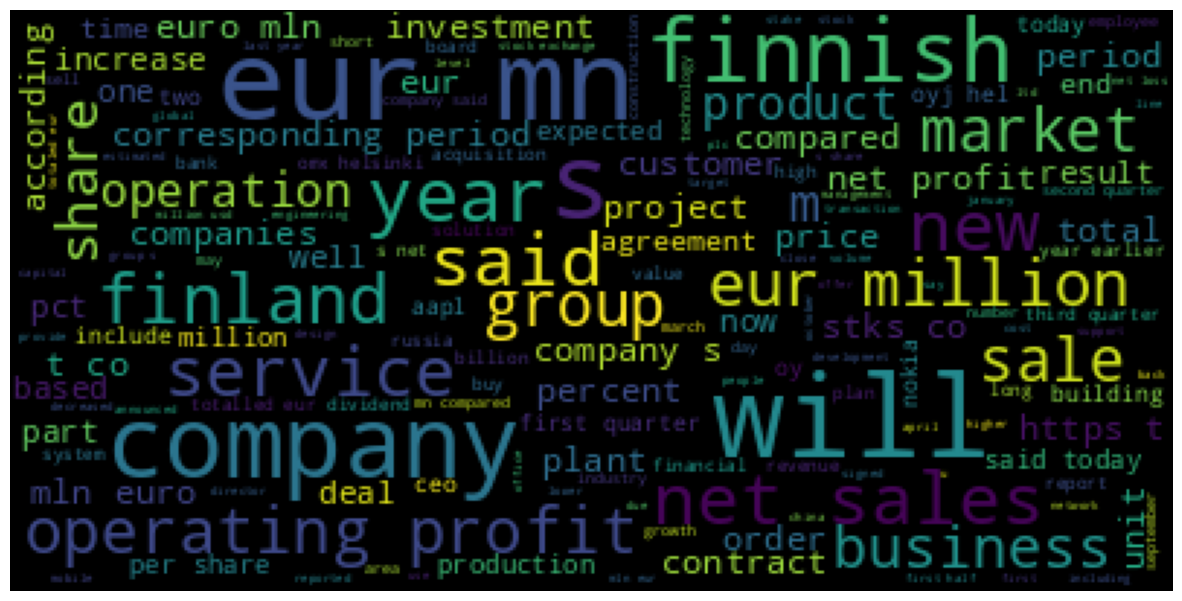

In [ ]:
show_wordcloud(df["Sentence"].values)

### Target Count
How many targets do we have? Learning this information will give us an idea about the model we will build. It will also provide guidance on our methods of analyzing data.

In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "bar"}]])
colors = ['gold', 'mediumturquoise', 'lightgreen'] # darkorange
fig.add_trace(go.Pie(labels=df["Sentiment"].value_counts().index, values=df["Sentiment"].value_counts().values), 1, 1)

fig.update_traces(hoverinfo='label+percent', textfont_size=20, marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.add_trace(go.Bar(x=df["Sentiment"].value_counts().index, y=df["Sentiment"].value_counts().values, marker_color = colors), 1,2)

fig.show()

### Token Counts with simple tokenizer
Finding out the number of tokens available for each sample will give us information about the length of our data. The classification algorithm we will use for a long text will not be the same as the algorithm used for a short text.

In [ ]:
# tokenize data
df["tokenized_review"] = df["Sentence"].apply(lambda x: tokenize(x))
# calculate token count for any sent
df["sent_token_length"] = df["tokenized_review"].apply(lambda x: len(x.split()))

In [ ]:
fig = px.histogram(df, x="sent_token_length", nbins=20, color_discrete_sequence=px.colors.cmocean.algae, barmode='group', histnorm="percent")
fig.show()

In [ ]:
(df.sent_token_length < 512).mean()

1.0

Token Counts with BERT tokenizer

Since we will create a Transformers-based model, the value that BERT tokinezer will give us is very important. With the information here, the value of the seq_len parameter that we will use while encoding the data will be decided.

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.5 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# data tokenize with bert tokenizer
df["sent_bert_token_length"] = df["Sentence"].apply(lambda x: len(tokenizer(x, add_special_tokens=False)["input_ids"]))

In [ ]:
fig = px.histogram(df, x="sent_token_length", nbins=20, color_discrete_sequence=px.colors.cmocean.algae, barmode='group', histnorm="percent")
fig.show()

In [ ]:
# Less than 512 covers how many of the data
(df.sent_bert_token_length < 512).mean()

1.0

### Characters Count in the Data
Let's look at the frequency of the number of characters. It will give us information about the overall size of our data

In [ ]:
# plot_dist3(df, 'char_count', 'Characters Count in Data')

### Reviews Lengths
When we look at the number of characters per comment, it can give us very striking information about the data. Here, when we look at the length of the comments made by people according to their feelings, negative comments are shorter than neutral and positive comments. We can come to the notion that people simply express negative things :)

In [ ]:
# plot_dist3(df[df['label'] == 0], 'Character Count', 'Characters Count "Negative" Review')

In [ ]:
# plot_dist3(df[df['label'] == 2], 'Character Count', 'Characters Per "Positive" Review')

In [ ]:
# plot_dist3(df[df['label'] == 1], 'Character Count', 'Characters Per "Neutral" Rewiev')

### Word Counts \
We see that the situation in the number of characters and the situation in the number of words are the same. We have seen that people use less word count when expressing negative things.

In [ ]:
# plot_word_number_histogram(df[df['label'] == 0]['Sentence'],
#                            df[df['label'] == 1]['Sentence'],
#                            df[df['label'] == 2]['Sentence'],
#                           )

In [ ]:
# remove punk
df['tokenized_review'] = df['tokenized_review'].apply(lambda x: remove_punct(x))

In [ ]:
texts = df['tokenized_review']
new = texts.str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:30]:
    if word not in stopWords_nltk:
        x.append(word)
        y.append(count)

fig = go.Figure(go.Bar(
            x=y,
            y=x,
            orientation='h',  marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Most common Word',))

fig.update_layout( title={
        'text': "Most Common Words",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))

fig.show()

Most Common ngrams

In [ ]:
fig = make_subplots(rows=1, cols=3)
title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = df[df["label"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []

    for word, count in most[:30]:
        if word not in stopWords_nltk:
            x.append(word)
            y.append(count)

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common ngrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
            family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ),)


fig.show()

In [ ]:
def _get_top_ngram(corpus, n=None):
    #getting top ngrams
    vec = CountVectorizer(ngram_range=(n, n),
                          max_df=0.9,
                          ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:15]

In [ ]:
# unigram
fig = make_subplots(rows=1, cols=3)

title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = df[df["label"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    top_n_bigrams = _get_top_ngram(texts, 2)[:15]
    x, y = map(list, zip(*top_n_bigrams))

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common unigrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))
fig.show()

In [ ]:
#trigram

fig = make_subplots(rows=1, cols=3)
title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = df[df["label"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    top_n_bigrams = _get_top_ngram(texts, 3)[:15]
    x, y = map(list, zip(*top_n_bigrams))

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1),

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common trigrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))

fig.show()

We examined and visualized the data, now we can move on to the model building part.

# 3. MODEL

A brief information about BERT\
https://www.kaggle.com/code/emirkocak/in-depth-series-sentiment-analysis-w-transformers?scriptVersionId=86920881&cellId=77

A brief information about XLNET \
https://www.kaggle.com/code/emirkocak/in-depth-series-sentiment-analysis-w-transformers?scriptVersionId=86920881&cellId=78

A brief information about RoBERTa \
https://www.kaggle.com/code/emirkocak/in-depth-series-sentiment-analysis-w-transformers?scriptVersionId=86920881&cellId=79

Comparison of Transformer Models \
https://www.kaggle.com/code/emirkocak/in-depth-series-sentiment-analysis-w-transformers?scriptVersionId=86920881&cellId=80

Preprocess for BERT Train

In [ ]:
import pandas as pd
import numpy as np
import os
import random
from pathlib import Path
import json

In [ ]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [ ]:
class Config():
    seed_val = 17
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    epochs = 5
    batch_size = 6
    seq_length = 512
    lr = 2e-5
    eps = 1e-8
    pretrained_model = 'bert-base-uncased'
    test_size=0.15
    random_state=42
    add_special_tokens=True
    return_attention_mask=True
    pad_to_max_length=True
    do_lower_case=False
    return_tensors='pt'

config = Config()

In [ ]:
# params will be saved after training
params = {"seed_val": config.seed_val,
    "device":str(config.device),
    "epochs":config.epochs,
    "batch_size":config.batch_size,
    "seq_length":config.seq_length,
    "lr":config.lr,
    "eps":config.eps,
    "pretrained_model": config.pretrained_model,
    "test_size":config.test_size,
    "random_state":config.random_state,
    "add_special_tokens":config.add_special_tokens,
    "return_attention_mask":config.return_attention_mask,
    "pad_to_max_length":config.pad_to_max_length,
    "do_lower_case":config.do_lower_case,
    "return_tensors":config.return_tensors,
         }

In [ ]:
# set random seed and device
import random

device = config.device

random.seed(config.seed_val)
np.random.seed(config.seed_val)
torch.manual_seed(config.seed_val)
torch.cuda.manual_seed_all(config.seed_val)

In [ ]:
df.head()

,Sentence,Sentiment,label,tokenized_review,sent_token_length,sent_bert_token_length
0,the geosolutions technology will leverage bene...,positive,2,the geosolutions technology will leverage bene...,29,34
1,esi on lows down 1 50 to 2 50 bk a real po...,negative,0,esi on lows down 1 50 to 2 50 bk a real possib...,13,15
2,for the last quarter of 2010 componenta s n...,positive,2,for the last quarter of 2010 componenta s net ...,44,50
3,according to the finnish russian chamber of co...,neutral,1,according to the finnish russian chamber of co...,19,19
4,the swedish buyout firm has sold its remaining...,neutral,1,the swedish buyout firm has sold its remaining...,22,23


Train and Validation Split

In [ ]:
#split train test
from sklearn.model_selection import train_test_split

train_df_, val_df = train_test_split(df, test_size=0.10, random_state=config.random_state, stratify=df.label.values)

In [ ]:
train_df_.head()

,Sentence,Sentiment,label,tokenized_review,sent_token_length,sent_bert_token_length
5076,shire share price under pressure after 32bn b...,negative,0,shire share price under pressure after 32 bn b...,10,12
5093,nflx 3 of the lows,positive,2,nflx 3 of the lows,5,7
524,okmetic s products are based on high tech exp...,positive,2,okmetic s products are based on high tech expe...,24,26
2683,ponsse will divide its sales and maintenance s...,neutral,1,ponsse will divide its sales and maintenance s...,13,15
89,in september 2010 the finnish group agreed t...,positive,2,in september 2010 the finnish group agreed to ...,29,30


In [ ]:
train_df, test_df = train_test_split(train_df_, test_size=0.10, random_state=42, stratify=train_df_.label.values)

In [ ]:
# count of unique label  control
print(len(train_df['label'].unique()))
print(train_df.shape)

3
(4372, 6)


In [ ]:
# count of unique label  control
print(len(val_df['label'].unique()))
print(val_df.shape)

3
(540, 6)


In [ ]:
print(len(test_df['label'].unique()))
print(test_df.shape)

3
(486, 6)


BertTokenizer and Encoding the Data


In [ ]:
# create tokenizer
tokenizer = BertTokenizer.from_pretrained(config.pretrained_model, do_lower_case=config.do_lower_case)

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    train_df.Sentence.values,
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
)
encoded_data_val = tokenizer.batch_encode_plus(
    val_df.Sentence.values,
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_df.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val_df.label.values)

In [ ]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

### Creating the Model
- bert-base-uncased is a smaller pre-trained model.
- Using num_labels to indicate the number of output labels.

In [ ]:
model = BertForSequenceClassification.from_pretrained(config.pretrained_model,
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

### Data Loaders
- DataLoader combines a dataset and a sampler, and provides an iterable over the given dataset.
- We use RandomSampler for training and SequentialSampler for validation.
- Given the limited memory in my environment, I set batch_size=64.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=config.batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=config.batch_size)

Optimizer & Scheduler

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=config.lr,
                  eps=config.eps)


scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*config.epochs)

### Performance Metrics
We will use f1 score as performance metrics.

In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

### Training Loop

In [ ]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(config.device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    # calculate avareage val loss
    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [ ]:
config.device

device(type='cpu')

In [ ]:
model.to(config.device)

for epoch in tqdm(range(1, config.epochs+1)):

    model.train()

    loss_train_total = 0
    # allows you to see the progress of the training
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)

    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(config.device) for b in batch)


        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')

    tqdm.write(f'F1 Score (Weighted): {val_f1}');
# save model params and other configs
with Path('params.json').open("w") as f:
    json.dump(params, f, ensure_ascii=False, indent=4)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/729 [00:00<?, ?it/s]

### Test on validation set

In [ ]:
model.load_state_dict(torch.load(f'./_BERT_epoch_3.model', map_location=torch.device('cpu')))

In [ ]:
from sklearn.metrics import classification_report

preds_flat = np.argmax(predictions, axis=1).flatten()
print(classification_report(preds_flat, true_vals))

#4. ERROR ANALYSIS

In [ ]:
# step by step predictions on dataframe
# We do this to view predictions in the pandas dataframe and easily filter them and perform error analysis.

pred_final = []

for i, row in tqdm(val_df.iterrows(), total=val_df.shape[0]):
    predictions = []

    review = row["Review"]
    encoded_data_test_single = tokenizer.batch_encode_plus(
    [review],
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
    )
    input_ids_test = encoded_data_test_single['input_ids']
    attention_masks_test = encoded_data_test_single['attention_mask']


    inputs = {'input_ids':      input_ids_test.to(device),
              'attention_mask':attention_masks_test.to(device),
             }

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
    predictions = np.concatenate(predictions, axis=0)
    pred_final.append(np.argmax(predictions, axis=1).flatten()[0])

In [ ]:
# add pred into val_df
val_df["pred"] = pred_final

In [ ]:
#  Add control column for easier wrong and right predictions
control = val_df.pred.values == val_df.label.values
val_df["control"] = control

In [ ]:
# filtering false predictions
val_df = val_df[val_df.control == False]

In [ ]:
# buraları düzenle bbaaaabbaaaaa
# label to intent mapping
name2label = {"Negative":0,
              "Neutral":1,
             "Positive":2
             }
label2name = {v: k for k, v in name2label.items()}

val_df["pred_name"] = val_df.pred.apply(lambda x: label2name.get(x))

In [ ]:
from sklearn.metrics import confusion_matrix

# We create a confusion matrix to better observe the classes that the model confuses.
pred_name_values = val_df.pred_name.values
label_values = val_df.label_name.values
confmat = confusion_matrix(label_values, pred_name_values, labels=list(name2label.keys()))

In [ ]:
confmat

In [ ]:
df_confusion_val = pd.crosstab(label_values, pred_name_values)
df_confusion_val

In [ ]:
# save confissuan matrix df
df_confusion_val.to_csv("val_df_confusion.csv")

# 5. Inference

In [ ]:
test_df.head()

In [ ]:
encoded_data_test = tokenizer.batch_encode_plus(
    test_df.Review.values,
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
)

In [ ]:
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test_df.label.values)

In [ ]:
model = BertForSequenceClassification.from_pretrained(config.pretrained_model,
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(config.device)

model.load_state_dict(torch.load(f'./_BERT_epoch_3.model', map_location=torch.device('cpu')))

_, predictions_test, true_vals_test = evaluate(dataloader_validation)
# accuracy_per_class(predictions, true_vals, intent2label)

In [ ]:
from sklearn.metrics import classification_report

preds_flat_test = np.argmax(predictions_test, axis=1).flatten()
print(classification_report(preds_flat_test, true_vals_test))

In [ ]:
pred_final = []

for i, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    predictions = []

    review = row["Review"]
    encoded_data_test_single = tokenizer.batch_encode_plus(
    [review],
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
    )
    input_ids_test = encoded_data_test_single['input_ids']
    attention_masks_test = encoded_data_test_single['attention_mask']

     inputs = {'input_ids':      input_ids_test.to(device),
              'attention_mask':attention_masks_test.to(device),
             }

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
    predictions = np.concatenate(predictions, axis=0)
    pred_final.append(np.argmax(predictions, axis=1).flatten()[0])

In [ ]:
# add pred into test
test_df["pred"] = pred_final

In [ ]:
#  Add control column for easier wrong and right predictions
control = test_df.pred.values == test_df.label.values
test_df["control"] = control

In [ ]:
# filtering false predictions
test_df = test_df[test_df.control == False]

In [ ]:
test_df["pred_name"] = test_df.pred.apply(lambda x: label2name.get(x))

In [ ]:
from sklearn.metrics import confusion_matrix

# We create a confusion matrix to better observe the classes that the model confuses.
pred_name_values = test_df.pred_name.values
label_values = test_df.label_name.values
confmat = confusion_matrix(label_values, pred_name_values, labels=list(name2label.keys()))

In [ ]:
confmat

In [ ]:
df_confusion_test = pd.crosstab(label_values, pred_name_values)
df_confusion_test

# 6. References
1. [Hugging Face](https://huggingface.co/)
2. [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
3. [RoBERTa: A Robustly Optimized BERT Pretraining Approach](https://arxiv.org/abs/1907.11692)
4. [XLNet: Generalized Autoregressive Pretraining for Language Understanding](https://arxiv.org/abs/1906.08237)
5. [Coursera](https://www.coursera.org/projects/sentiment-analysis-bert)
6. [Brand24](https://brand24.com/)
7. [MonkeyLearn](https://monkeylearn.com/sentiment-analysis/)